# Caso Practico: Support Vector Machine (SVM).

* Algoritmo basado en **Aprendizaje supervisado.**
* Es un algoritmo capaz de ralizar **Regresión y Clasificación.**
* Funciona muy bien para **Conjuntos de datos complejos de tamaño pequeño o mediano.**
* Puede aplicarse a diferentes formas en función al DataSet:
    * Conjuntos de **Datos linealmente separables**.
        * **Hard Margin Classification**.
        * **Soft Margin Classificatiion**.
    * Conjuntos de **datos linealmente no separables**.
        * **Kernels**.

# Caso practico: Sport Vector Machine(SVM).
## Conjunto de datos: Deteccion de URLs Maliciosas.

### Descripcion.
The Web has long become a major platform for online criminal activities. URLs are used as the main vehicle in this domain. To counter this issues security community focused its efforts on developing techniques for mostly blacklisting of malicious URLs.

While successful in protecting users from known malicious domains, this approach only solves part of the problem. The new malicious URLs that sprang up all over the web in masses commonly get a head start in this race. Besides that, Alexa ranked, trusted websites may convey compromised fraudulent URLs called defacement URL.

We study mainly five different types of URLs:

Benign URLs: Over 35,300 benign URLs were collected from Alexa top websites. The domains have been passed through a Heritrix web crawler to extract the URLs. Around half a million unique URLs are crawled initially and then passed to remove duplicate and domain only URLs. Later the extracted URLs have been checked through Virustotal to filter the benign URLs.

Spam URLs: Around 12,000 spam URLs were collected from the publicly available WEBSPAM-UK2007 dataset.

Phishing URLs: Around 10,000 phishing URLs were taken from OpenPhish which is a repository of active phishing sites.

Malware URLs: More than 11,500 URLs related to malware websites were obtained from DNS-BH which is a project that maintain list of malware sites.

Defacement URLs: More than 45,450 URLs belong to Defacement URL category. They are Alexa ranked trusted websites hosting fraudulent or hidden URL that contains both malicious web pages.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline


## Funciones auxiliares.


In [2]:
# Construccion de un funcion que realice el particionadocopleto.
def train_val_test_split(df,rstate=42,shuffle=True,stratify=None):
    sstrat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
               df, test_size=0.4, random_state=rstate,shuffle=shuffle, stratify =sstrat)
    strat=test_set[stratify ]if stratify else None
    val_set, test_set=train_test_split(
    test_set,test_size = 0.5, random_state = rstate, shuffle=shuffle, stratify =strat)
    return(train_set,val_set,test_set)

In [3]:
# Reperecentacion grafica del limite de decision
def plot_svm_decision_boundary(svm_clf, xmin,xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    
    # at the decision boundary, w0*x0 + w1*x1 + b = 0
    # => = -w/w1 * x0 - b/w1
    
    x0 =np.linespace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    
    margin = 1/w [1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svm = svm_clf.support_vectors_
    plt.scatter(svm[:, 0], svm[:,1], s = 180, facecolors = '#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth = 2)
    plt.plot(x0, gutter_up, "k--", linewidth = 2)
    plt.plot(x0, gutter_down, "k-", linedidth = 2)
    

## 1.-Lectura del DataSet.

In [4]:
df = pd.read_csv("datasets/FinalDataset/Phishing.csv")

In [5]:
## 2.- Visualizacion prelimianr de la informacion.

In [6]:
df.head(10)

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,2,12,5.5,8,4.083334,2,15,7,0,...,-1,-1,-1,0.676804,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
1,0,3,12,5.0,10,3.583333,3,12,8,2,...,1,0,-1,0.715629,0.776796,0.693127,0.738315,1.00000,-1.000000,benign
2,2,2,11,4.0,5,4.750000,2,16,11,0,...,2,0,1,0.677701,1.000000,0.677704,0.916667,0.00000,0.898227,benign
3,0,2,7,4.5,7,5.714286,2,15,10,0,...,0,0,-1,0.696067,0.879588,0.818007,0.753585,0.00000,-1.000000,benign
4,19,2,10,6.0,9,2.250000,2,9,5,0,...,5,4,3,0.747202,0.833700,0.655459,0.829535,0.83615,0.823008,benign
5,0,2,10,5.5,9,4.100000,2,15,11,0,...,-1,-1,-1,0.732981,0.860529,-1.000000,-1.000000,-1.00000,-1.000000,benign
6,0,2,12,4.5,6,5.333334,2,24,9,0,...,0,0,-1,0.692383,0.939794,0.910795,0.673973,0.00000,-1.000000,benign
7,0,2,11,3.5,4,3.909091,2,15,6,0,...,0,0,-1,0.707365,0.916667,0.916667,0.690332,0.00000,-1.000000,benign
8,0,2,9,2.5,3,4.555555,2,6,3,0,...,1,0,-1,0.742606,1.000000,0.785719,0.808833,1.00000,-1.000000,benign
9,0,2,13,4.5,6,5.307692,2,16,9,1,...,-1,-1,-1,0.734633,0.939794,-1.000000,-1.000000,-1.00000,-1.000000,benign


In [7]:
df["URL_Type_obf_Type"].value_counts()

URL_Type_obf_Type
benign      7781
phishing    7586
Name: count, dtype: int64

In [8]:
# Comprobar si existen valores nulos
is_null = df.isna().any()
is_null[is_null]

avgpathtokenlen             True
NumberRate_DirectoryName    True
NumberRate_FileName         True
NumberRate_Extension        True
NumberRate_AfterPath        True
Entropy_DirectoryName       True
Entropy_Filename            True
Entropy_Extension           True
Entropy_Afterpath           True
dtype: bool

In [9]:
# Comprobacion si existen valores infinitos
is_inf = df.isin([np.inf, -np.inf]).any()
is_inf[is_inf]

argPathRatio    True
dtype: bool

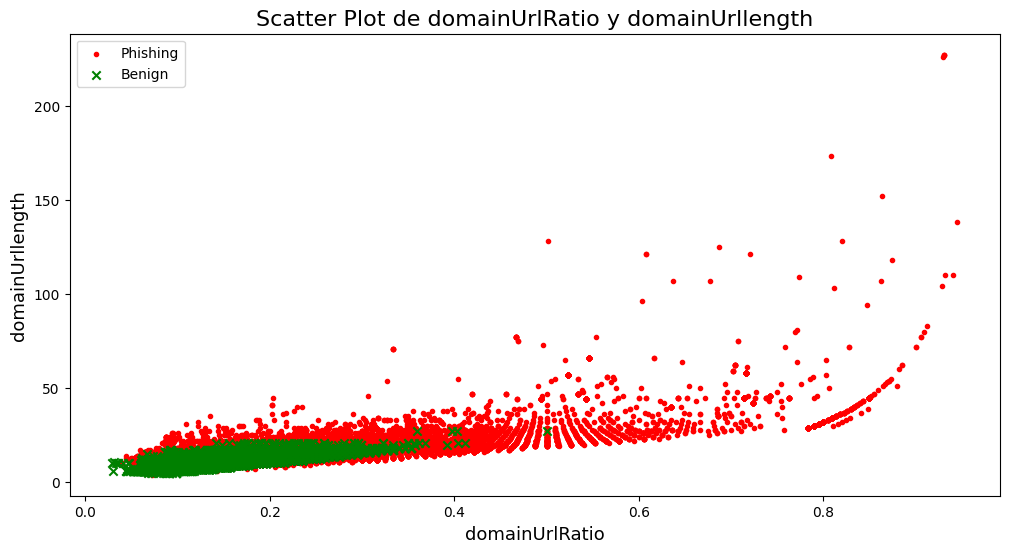

In [10]:
# Representacion grafica de dos caracteristicas
plt.figure(figsize=(12, 6))
plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type'] == "phishing"],
            df["domainlength"][df['URL_Type_obf_Type'] == "phishing"],
            c="r", marker=".", label="Phishing")

plt.scatter(df["domainUrlRatio"][df['URL_Type_obf_Type'] == "benign"],
            df["domainlength"][df['URL_Type_obf_Type'] == "benign"],
            c="g", marker="x", label="Benign")

plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainUrllength", fontsize=13)
plt.legend()  # Agregamos leyenda para diferenciar entre phishing y benign
plt.title("Scatter Plot de domainUrlRatio y domainUrllength", fontsize=16)
plt.show()

## 3.-Division del dataset

In [11]:
train_set, val_set, test_set = train_val_test_split(df)

In [12]:
X_train = train_set.drop("URL_Type_obf_Type", axis = 1)
y_train = train_set["URL_Type_obf_Type"].copy()

X_val = val_set.drop("URL_Type_obf_Type", axis = 1)
y_val = val_set["URL_Type_obf_Type"].copy()

X_test = test_set.drop("URL_Type_obf_Type", axis = 1)
y_test = test_set["URL_Type_obf_Type"].copy()

## 4.-Preparar el DataSet.

In [13]:
# Eliminar los atributos que tienen valores infinitos
X_train = X_train.drop("argPathRatio", axis = 1)
X_val = X_val.drop("argPathRatio", axis = 1)
X_test = X_test.drop("argPathRatio", axis = 1)

In [14]:
# Rellenar los valores nulos con la mediana
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")


In [15]:
# Rellena rlos valores nulos
X_train_prep = imputer.fit_transform(X_train)
X_val_prep = imputer.fit_transform(X_val)
X_test_prep = imputer.fit_transform(X_test)

In [16]:
#Transformar el resultado a un DataFrame de Pandas.
X_train_prep = pd.DataFrame(X_train_prep, columns = X_train.columns, index = y_train.index)
X_val_prep = pd.DataFrame(X_val_prep, columns = X_val.columns, index = y_val.index)
X_test_prep = pd.DataFrame(X_test_prep, columns = X_test.columns, index = y_test.index)

In [17]:
# Comprobar si hay valores nulos en el DataSet de entrenamiento
is_null = X_train_prep.isna().any()
is_null[is_null]

Series([], dtype: bool)

## 5.-SVM: Kernel Lineal.

Entrenamiento del algoritmo con un DataSet reducido.

In [18]:
# Reducir el conjunto de datos para reoresentarlo graficamente.
X_train_reduced = X_train_prep[["domainUrlRatio", "domainlength"]].copy()
X_val_reduced = X_val_prep[["domainUrlRatio", "domainlength"]].copy()

In [19]:
X_train_reduced

,domainUrlRatio,domainlength
2134,0.072464,5.0
9178,0.166667,16.0
13622,0.511628,22.0
15182,0.315789,12.0
8013,0.107527,20.0
...,...,...
5191,0.116667,14.0
13418,0.477273,21.0
5390,0.157895,9.0
860,0.072917,7.0


In [20]:
from sklearn.svm import SVC
# SVM Large Margin Clasification
svm_clf = SVC(kernel = "linear", C = 50)
svm_clf.fit(X_train_reduced, y_train)

SVC(C=50, kernel='linear')

#### Representacion del limite de decicion.

In [21]:
# Representacion grafica del limite de decision
def plot_svm_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # at the decision boundary, w0*x0 + w1*x1 + b = 0
    # => = -w/w1 * x0 - b/w1
    
    x0 = np.linspace(xmin, xmax, 200)  # Corregido aquí
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1 / np.linalg.norm(w)
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svm = svm_clf.support_vectors_
    
    plt.scatter(svm[:, 0], svm[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k-", linewidth=2)

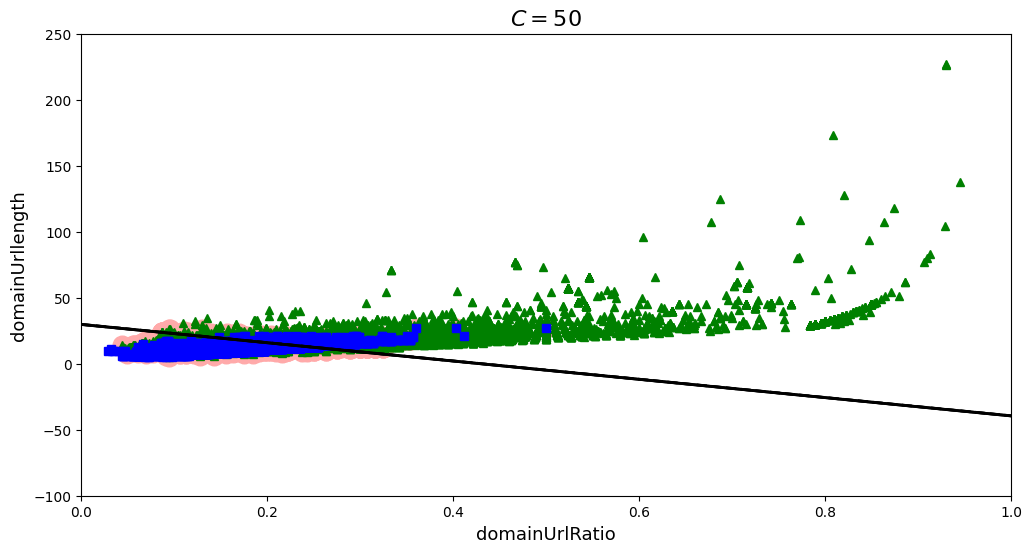

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(X_train_reduced.values[:, 0][y_train == "phishing"], X_train_reduced.values[:, 1][y_train == "phishing"], "g^")
plt.plot(X_train_reduced.values[:, 0][y_train == "benign"], X_train_reduced.values[:, 1][y_train == "benign"], "bs")
plot_svm_decision_boundary(svm_clf, 0, 1)
plt.title("$C = {}$".format(svm_clf.C), fontsize=16)  # Corregido aqui
plt.axis([0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainUrllength", fontsize=13)
plt.show()

In [23]:
# Representacion grafica del limite de decision
def plot_svm_decision_boundary(svm_clf, X, y, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # at the decision boundary, w0*x0 + w1*x1 + b = 0
    # => = -w/w1 * x0 - b/w1
    
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0] / w[1] * x0 - b / w[1]

    margin = 1 / np.linalg.norm(w)
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svm_support = svm_clf.support_vectors_
    
    plt.scatter(X[:, 0][y == "phishing"], X[:, 1][y == "phishing"], c="g", marker="^", label="Phishing")
    plt.scatter(X[:, 0][y == "benign"], X[:, 1][y == "benign"], c="b", marker="s", label="Benign")
    plt.scatter(svm_support[:, 0], svm_support[:, 1], s=180, facecolors='none', edgecolors='#FFAAAA', label="Support Vectors")
    
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k-", linewidth=2)

In [24]:
# Usar los datos originales
X_data = df[["domainUrlRatio", "domainlength"]].values
y_data = df["URL_Type_obf_Type"].values

In [25]:
# Crear y entrenar el clasificador SVM
svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X_data, y_data)

SVC(C=1, kernel='linear')

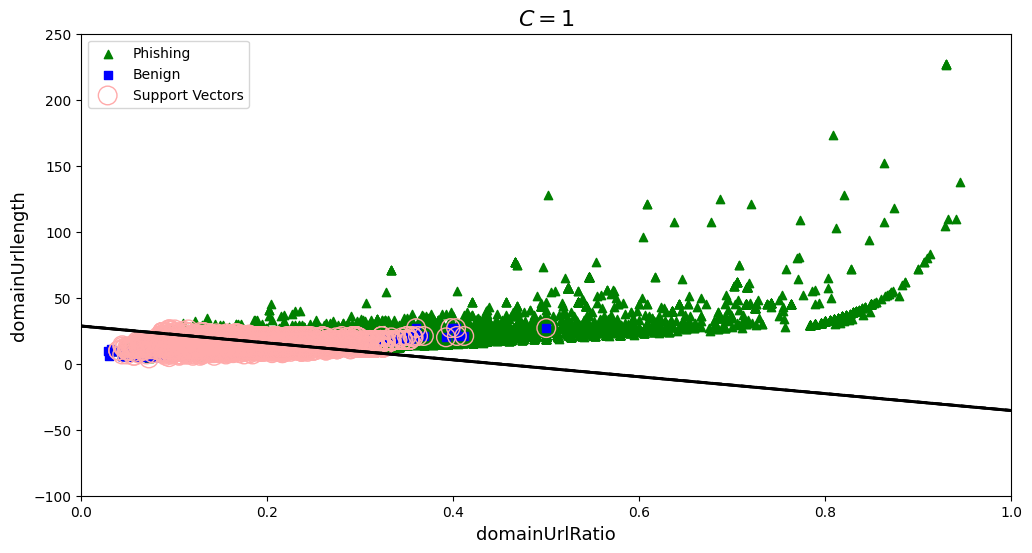

In [26]:
plt.figure(figsize=(12, 6))
plot_svm_decision_boundary(svm_clf, X_data, y_data, 0, 1)
plt.title("$C = {}$".format(svm_clf.C), fontsize=16)
plt.axis([0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=13)
plt.ylabel("domainUrllength", fontsize=13)
plt.legend()
plt.show()

### Prediccion con un conjunto de datos reducidos.

In [27]:
y_pred = svm_clf.predict(X_val_reduced)

/home/hector/anaconda3/envs/python/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [28]:
print("F1 Score: ", f1_score(y_pred, y_val, pos_label = 'phishing'))

F1 Score:  0.8173207036535859


#### Como se vera mas adelante, para determinados kernels es muy importante escalar el data set. En ese caso, para el kernel lineal no es tan relevante aunque es posible que proporcione mejores resultados

In [29]:
svm_clf_sc = Pipeline([
    ("scaler", RobustScaler()),
    ("linear_svm", SVC(kernel = "linear", C = 50)),
])

svm_clf_sc.fit(X_train_reduced, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('linear_svm', SVC(C=50, kernel='linear'))])

In [30]:
y_pred = svm_clf_sc.predict(X_val_reduced)

In [31]:
print("F1 Score: ", f1_score(y_pred, y_val, pos_label = 'phishing'))

F1 Score:  0.8141592920353983


## 5.2 Conjunto de datos completo.

In [32]:
# ENtrenamiento con todo el conjunto de datos
from sklearn.svm import SVC
svm_clf = SVC(kernel = "linear", C = 1)
svm_clf.fit(X_train_prep, y_train)

SVC(C=1, kernel='linear')

In [33]:
y_pred = svm_clf.predict(X_val_prep)

In [34]:
print("F1 Score: ", f1_score(y_pred, y_val, pos_label = 'phishing'))

F1 Score:  0.9611330698287219


In [35]:
# Calcular el recall
from sklearn.metrics import recall_score, precision_score
recall = recall_score(y_val, y_pred, pos_label='phishing')

print("Recall: ", recall)

# Calcular la precisión
precision = precision_score(y_val, y_pred, pos_label='phishing')


print("Precision: ", precision)

Recall:  0.96494708994709
Precision:  0.9573490813648294


## 6. SVM Kernel no Lineal

### Polynominal Kernel (I)

#### Entrenamiento del algoritmo con un conjunto de datos reducido.

In [37]:
# Para representar el liminte de decision se tiene que pasar la variabla objetivo a numerica.
y_train_num = y_train.factorize()[0]
y_val_num = y_val.factorize()[0]

In [40]:
from sklearn.datasets import make_moons
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures (degree = 3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C = 20, loss = "hinge", random_state = 42, max_iter = 100000))
])

polynomial_svm_clf.fit(X_train_reduced, y_train_num)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf',
                 LinearSVC(C=20, loss='hinge', max_iter=100000,
                           random_state=42))])

#### Representacion del limite de decision.

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def plot_dataset(X, y):
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "g.")
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "b.")

/home/hector/anaconda3/envs/python/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/home/hector/anaconda3/envs/python/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


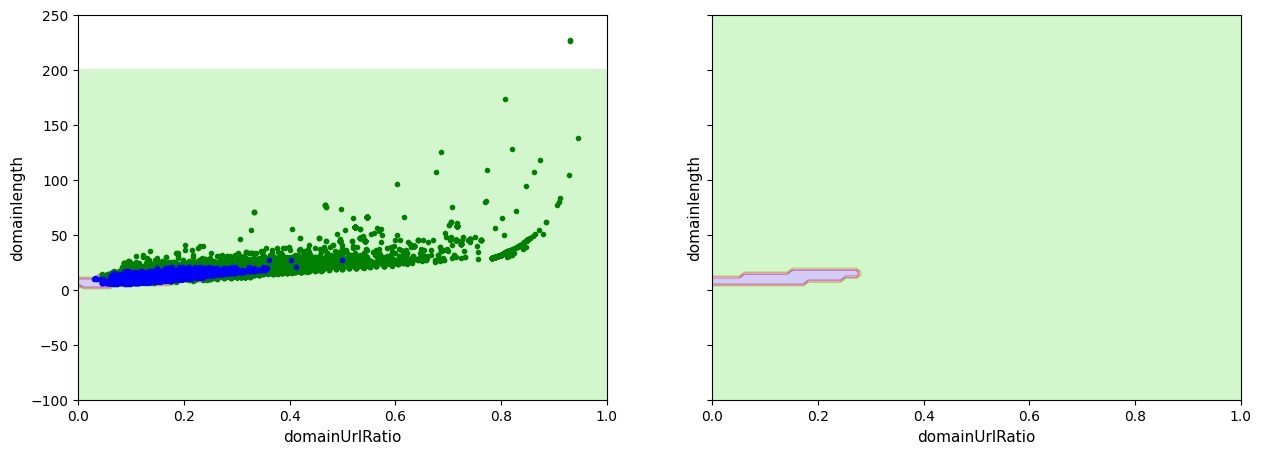

In [46]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

# Crear la figura y los ejes fuera de las funciones
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

plt.sca(axes[0])
plot_dataset(X_train_reduced.values, y_train_num)
plot_predictions(polynomial_svm_clf, [0, 1, -100, 200])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)

plt.sca(axes[1])
plot_predictions(polynomial_svm_clf, [0, 1, -100, 250])
plt.xlabel("domainUrlRatio", fontsize=11)
plt.ylabel("domainlength", fontsize=11)

plt.show()
